In [90]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns

import lib.torch_device as tdev

from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.model.sliding_attention_classifier import SlidingAttentionClassifier, SlidingAttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv, train_model, evaluate_model
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics

import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [80]:
rng = np.random.default_rng()

def create_random_sequences(
    n_sequences: int, 
    sequence_length: int, 
    segments: list[list[int]], 
    segments_end_labels: list[int]
) -> NumpyDataset:
    sequences = np.zeros((n_sequences, sequence_length, 1))
    labels = np.zeros((n_sequences, sequence_length)).astype(int)
    
    for sequence_nr in range(n_sequences):
        sequence: list[int] = []
        sequence_labels: list[int] = []
        
        while len(sequence) < sequence_length:
            timesteps_left = sequence_length - len(sequence)
            
            if rng.uniform() < 0.5:
                available_segments = [
                    (seg, seg_end_label)
                    for seg, seg_end_label 
                    in zip(segments, segments_end_labels) 
                    if len(seg) <= timesteps_left
                ]
                segment, segment_end_label = available_segments[rng.choice(len(available_segments))]
                
                sequence.extend(segment)
                sequence_labels.extend(([0] * (len(segment) - 1)) + [segment_end_label])
                
                timesteps_left = sequence_length - len(sequence)
            
            if timesteps_left > 0:
                zeros = [0] * (rng.integers(0, rng.integers(0, timesteps_left) + 1) + 1)
                sequence.extend(zeros)
                sequence_labels.extend(zeros)
        
        sequences[sequence_nr, :, 0] = np.array(sequence)
        labels[sequence_nr, :] = np.array(sequence_labels)
    
    return NumpyDataset(sequences, labels)
    

def create_sequences_with_segment(sequence_length: int, segment: list[int], segment_end_label: int):
    sequences: list[np.ndarray] = []
    labels: list[np.ndarray] = []
    segment_length = len(segment)
    
    for i in range(sequence_length - segment_length + 1):
        seq = np.zeros(sequence_length)
        l = np.zeros(sequence_length).astype(int)
        
        seq[i:i + segment_length] = np.array(segment)
        l[i + segment_length - 1] = segment_end_label
            
        sequences.append(seq)
        labels.append(l)
    
    return sequences, labels

data = np.array([
    *(create_sequences_with_segment(8, [1], segment_end_label=0)[0]),
    *(create_sequences_with_segment(8, [1, 1], segment_end_label=0)[0]),
    *(create_sequences_with_segment(8, [1, 1, 1], segment_end_label=0)[0]),
    *(create_sequences_with_segment(8, [1, 1, 1, 1], segment_end_label=0)[0]),
])[:, :, np.newaxis]
labels = np.array([
    *(create_sequences_with_segment(8, [1], segment_end_label=1)[1]),
    *(create_sequences_with_segment(8, [1, 1], segment_end_label=0)[1]),
    *(create_sequences_with_segment(8, [1, 1, 1], segment_end_label=1)[1]),
    *(create_sequences_with_segment(8, [1, 1, 1, 1], segment_end_label=0)[1]),
]).astype(int)

ds = create_random_sequences(
    n_sequences=10000,
    sequence_length=100,
    segments=[
        [1],
        [1, 1],
        [1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1, 1],
    ],
    segments_end_labels=[
        1,
        0,
        1,
        0,
        1
    ]
)

print(f'{ds.data.shape   = }')
print(f'{ds.labels.shape = }')

# for i in range(ds.data.shape[0]):
#     print(ds.data[i, :, 0], ds.labels[i])

ds.data.shape   = (10000, 100, 1)
ds.labels.shape = (10000, 100)
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1.] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0.] [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

# Hyper Parameters

In [91]:
ac_hyper_parameters = SlidingAttentionClassifierHyperParameters(
    in_features=ds.data.shape[-1],
    out_features=2,
    
    attention_window_size=30,
    stride=10,
    
    d_model=64,
    num_heads=16,
    attention_stack_size=2,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[128, 64, 64],
    out_linear_hidden_out_features=[32, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [100]:
training_hyper_parameters = TrainingHyperParameters(
        batch_size=17,
        
        loss_weight_modifiers=torch.Tensor([100, 1]),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=5,
        lr=1e-2,
    
        lr_scheduler_milestones=[int(m) for m in [30, 100, 250]],
        lr_scheduler_gamma=0.75,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training



#### Training ####
##################
SlidingAttentionClassifier with 52754 parameters, in_fnn: 16832, attention_stack: 33280, out_fnn: 2642
##################

train label counts = [973098, 26902]
eval label counts  = [973098, 26902]

loss weights                    = [100.00, 36.17]
eval loss weights (theoretical) = [100.00, 36.17]


Training Epoch   1/5  : lr = 1.00E-02, epoch =     1, avg_loss = 0.000034, num_samples = 1000000, num_correct = 971184, acc = 0.971184, bacc = 0.500047, score = 0.942368
Evaluation Epoch   1/5  : epoch =     1, avg_loss = 0.000050, num_samples = 1000000, num_correct = 973098, acc = 0.973098, bacc = 0.500000, score = 0.946196
Training Epoch   2/5  : lr = 1.00E-02, epoch =     2, avg_loss = 0.000012, num_samples = 1000000, num_correct = 979253, acc = 0.979253, bacc = 0.632234, score = 0.958506
Evaluation Epoch   2/5  : epoch =     2, avg_loss = 0.000016, num_samples = 1000000, num_correct = 983273, acc = 0.983273, bacc = 0.690106, score = 0.966546
Traini

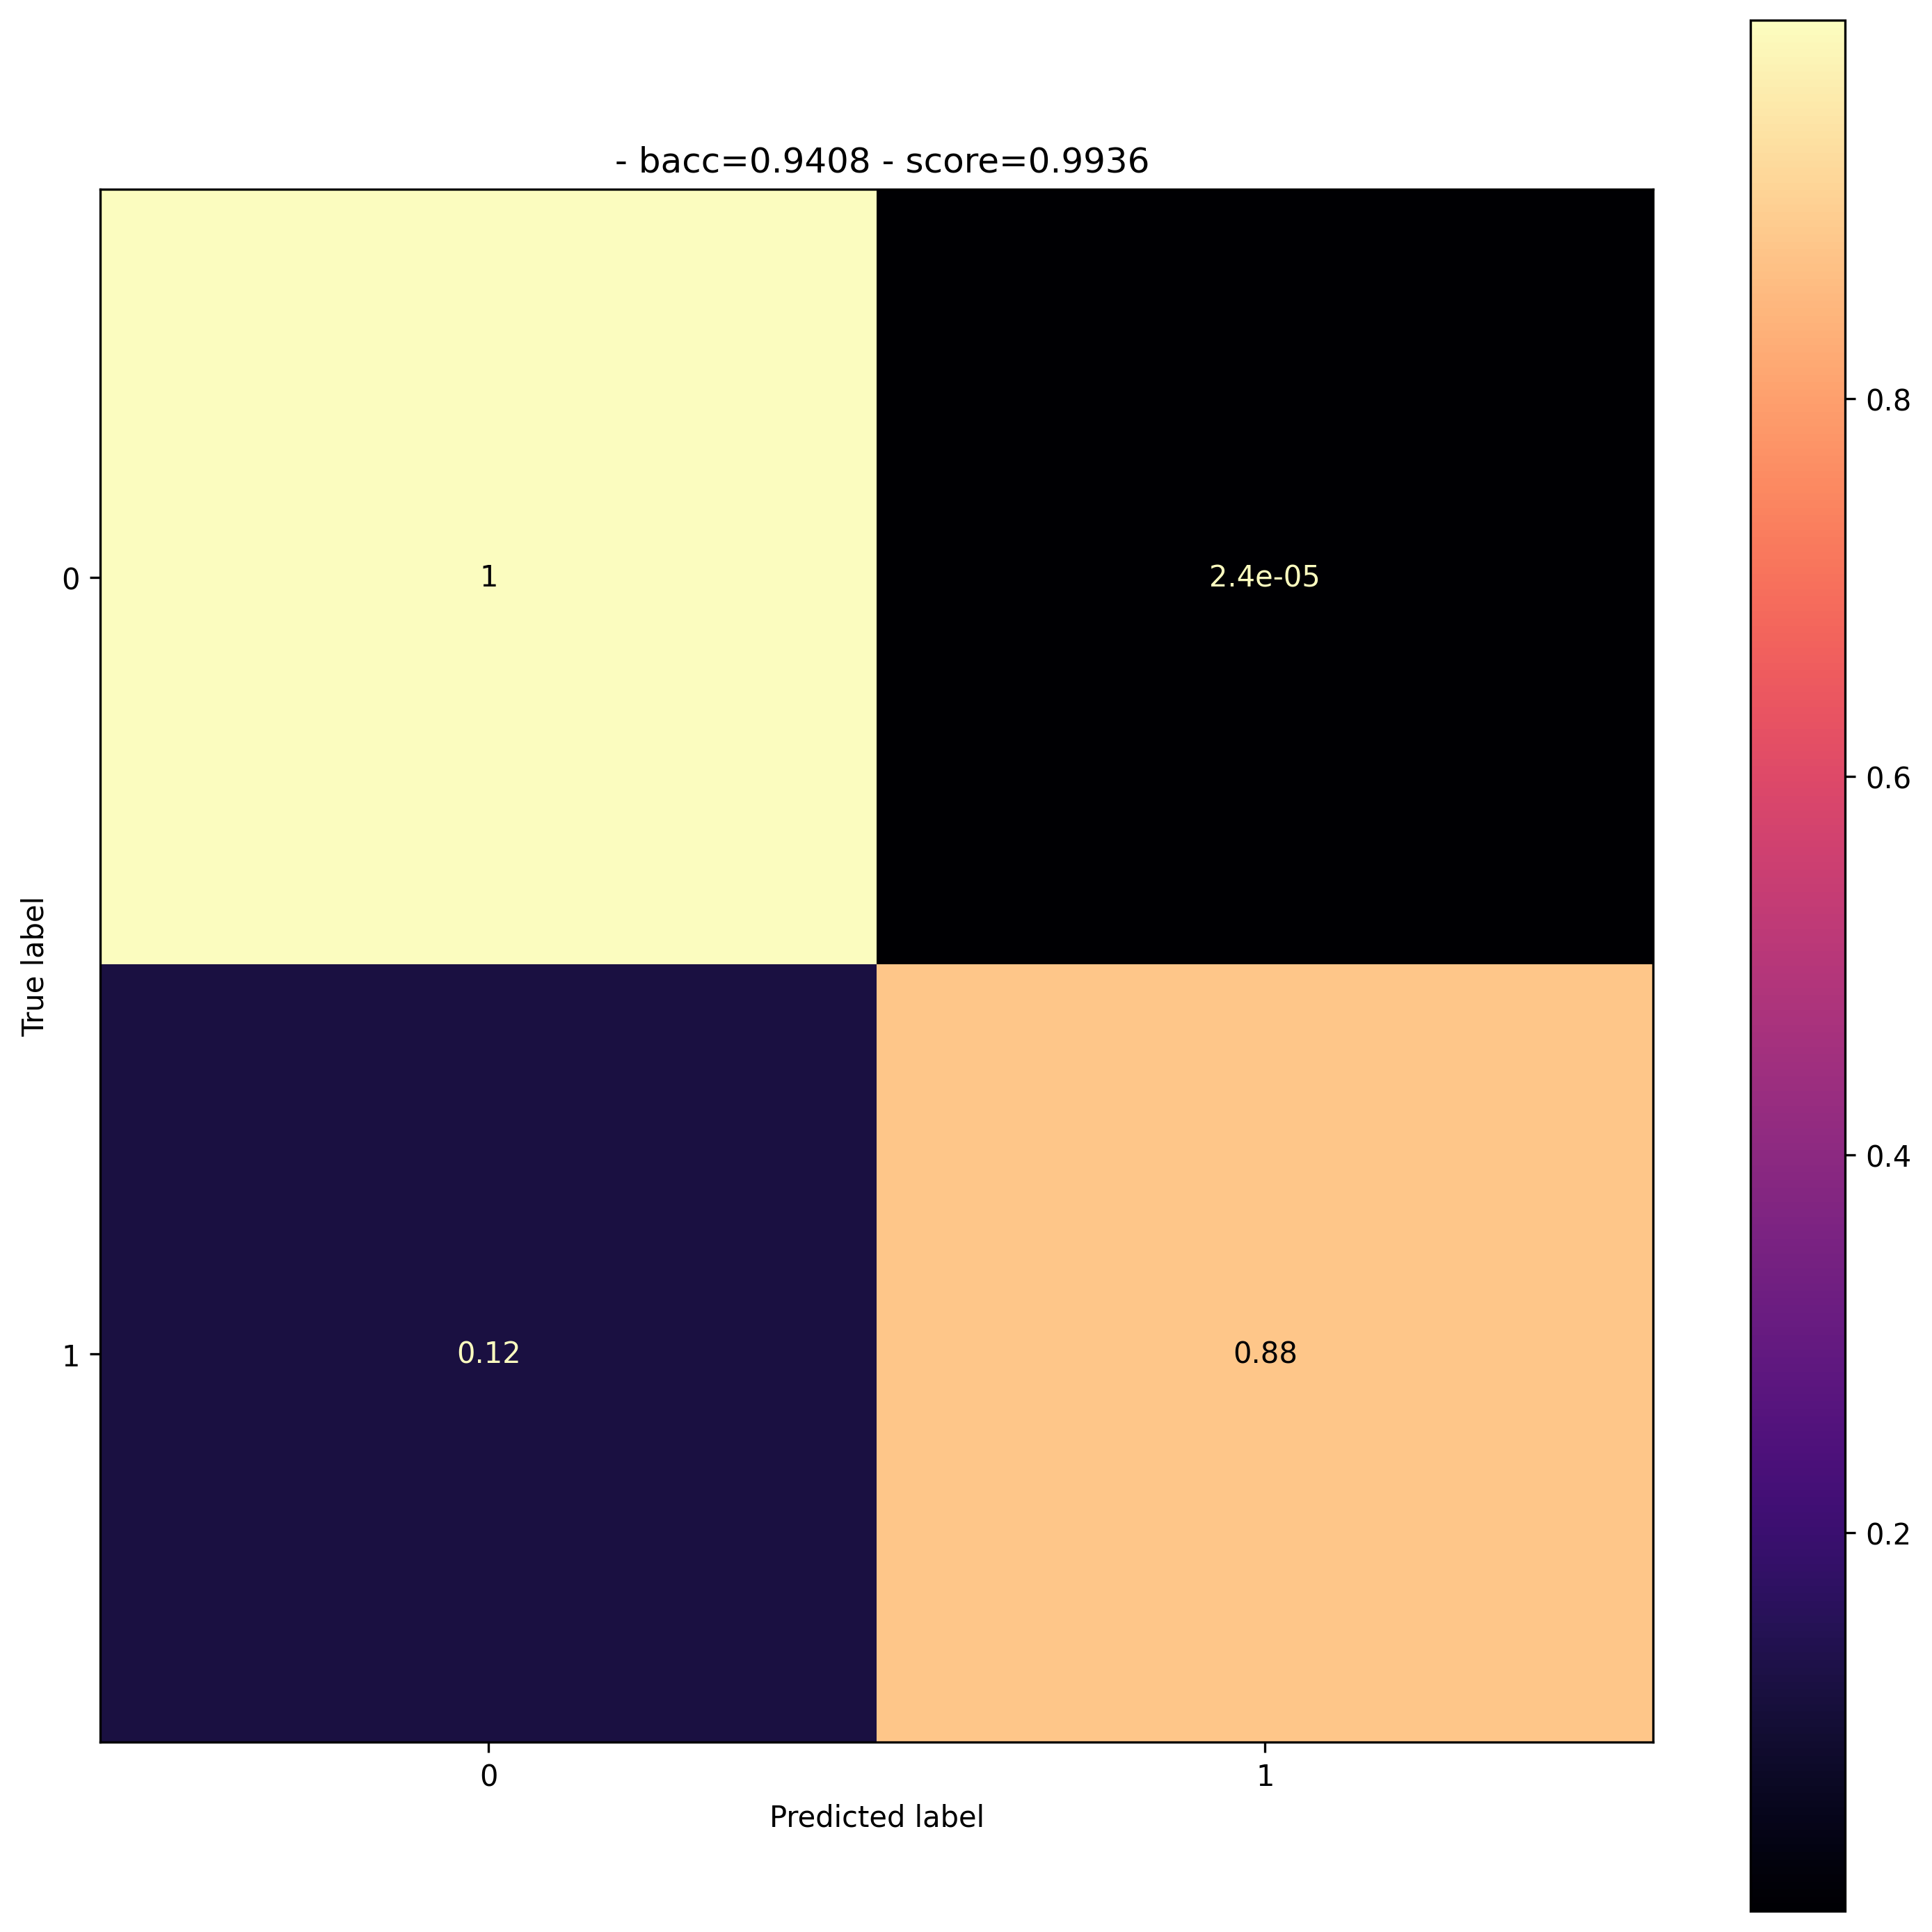

epoch =    -1, avg_loss = 0.000005, num_samples = 1000000, num_correct = 996793, acc = 0.996793, bacc = 0.940810, score = 0.993586

In [101]:
ac = SlidingAttentionClassifier(ac_hyper_parameters, batch_first=True)
    
train_model(
    ac,
    training_hyper_parameters,
    ds,
    ds,
    device
)

evaluate_model(ac, create_data_loader(ds.data, ds.labels, 20, False), device, show_confmat=True, confmat_title='')

In [102]:
def predict_for_sequence(seq: list[int]):
    return torch.argmax(ac.forward(torch.Tensor([[[float(e)] for e in seq]]).to(device)), axis=2)

In [72]:
print('Train')
print(f'{predict_for_sequence([1, 0, 0, 0, 0, 0, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 1, 0, 0, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 0, 0, 0, 0, 1]) = }')
print()
print(f'{predict_for_sequence([ 1, 1, 0, 0, 0, 0,0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 0, 1, 1, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 0, 0, 0, 1, 1]) = }')
print()
print(f'{predict_for_sequence([ 1, 1, 1, 0, 0, 0,0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 1, 1, 1, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 0, 0, 1, 1, 1]) = }')
print()
print(f'{predict_for_sequence([1, 1, 1, 1, 0, 0, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 1, 1, 1, 1, 0, 0]) = }')
print(f'{predict_for_sequence([0, 0, 0, 0, 1, 1, 1, 1]) = }')

print()
print()

print('Test')

print(f'{predict_for_sequence([0, 0, 0, 1, 0, 1, 0, 1]) = }')
print(f'{predict_for_sequence([1, 0, 0, 0, 0, 1, 0, 1]) = }')
print(f'{predict_for_sequence([1, 1, 0, 0, 0, 0, 0, 1]) = }')

Train


RuntimeError: shape '[100, -1, 1]' is invalid for input of size 8

In [103]:
print(f'{predict_for_sequence(([0] * 92) + [1, 0, 0, 0, 0, 0, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 1, 0, 0, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 0, 0, 0, 1])[0, 92:] = }')
print()
print(f'{predict_for_sequence(([0] * 92) + [ 1, 1, 0, 0, 0, 0,0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 1, 1, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 0, 0, 1, 1])[0, 92:] = }')
print()
print(f'{predict_for_sequence(([0] * 92) + [ 1, 1, 1, 0, 0, 0,0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 1, 1, 1, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 0, 1, 1, 1])[0, 92:] = }')
print()
print(f'{predict_for_sequence(([0] * 92) + [1, 1, 1, 1, 0, 0, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 1, 1, 1, 1, 0, 0])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 1, 1, 1, 1])[0, 92:] = }')

print()
print()


print(f'{predict_for_sequence(([0] * 92) + [0, 0, 0, 1, 0, 1, 0, 1])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [1, 0, 0, 0, 0, 1, 0, 1])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [1, 1, 0, 0, 0, 0, 0, 1])[0, 92:] = }')
print(f'{predict_for_sequence(([0] * 92) + [1, 1, 0, 0, 0, 0, 0, 1])[0, 92:] = }')

predict_for_sequence(([0] * 92) + [1, 0, 0, 0, 0, 0, 0, 0])[0, 92:] = tensor([1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 0, 0, 1, 0, 0, 0, 0])[0, 92:] = tensor([0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 0, 0, 0, 1])[0, 92:] = tensor([0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')

predict_for_sequence(([0] * 92) + [ 1, 1, 0, 0, 0, 0,0, 0])[0, 92:] = tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 1, 1, 0, 0])[0, 92:] = tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 0, 0, 0, 0, 0, 1, 1])[0, 92:] = tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

predict_for_sequence(([0] * 92) + [ 1, 1, 1, 0, 0, 0,0, 0])[0, 92:] = tensor([0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 0, 0, 1, 1, 1, 0, 0])[0, 92:] = tensor([0, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
predict_for_sequence(([0] * 92) + [0, 